In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import os
import matplotlib.pyplot as plt
import json

# Data cleaning

In [12]:
foldernames = [
    './TRAININGS/items_scale_ending-16_08_2022__18:31:04',
]
labels = ['cushman']
dfs = []
dfs_with_unclear = []

dataset = json.load(
    open('data/cushman_2006/items_scale_ending.json'))
dataset = pd.DataFrame(dataset)

for label, foldername in zip(labels, foldernames):
    df = pd.read_csv(open(foldername+'/results.csv', 'r'))
    df['exp'] = label
    df['a'] = df['a'].str.lower()
    df = df[df['q_id'] == 0]
    df = df[~df['item_id'].isin([1, 2])]
    for i in df['item_id'].unique():
        if i not in (1, 2):

            df.loc[df['item_id'] == i, 'title'] = \
                str(dataset[dataset['id'] == i]['title'].unique()[0])[2:]
            df.loc[df['item_id'] == i, 'cond'] = \
                str(dataset[dataset['id'] == i]['title'].unique()[0])[:2]

    df['principle'] = ''
    df['principle'] = df['principle'].astype('object')
    df.loc[df['cond'].str.contains('ik|ci|fk|cf'), 'principle'] += ' action '
    df.loc[df['cond'].str.contains('l'), 'principle'] += ' inaction '
    df.loc[df['cond'].str.contains('f'), 'principle'] += ' foreseen '
    df.loc[df['cond'].str.contains('i'), 'principle'] += ' intended '
    df.loc[df['cond'].str.contains('c'), 'principle'] += ' contact '
    df.loc[~df['cond'].str.contains('c'), 'principle'] += ' no_contact '
    df['val'] = df['a'].str.extract(pat=r'(\d+)')
    df['val'] = df['val'].astype(int)
    df['yes'] = df['val'] >= 4
    df['no'] = df['val'] < 4
    print(df['val'].unique())


    dfs.append(df.copy())

df = pd.concat(dfs)

def mean_by_exp_and_sub(df):
    # set cond label and merge
    exp = df['exp'].unique()
    dfs = []
    for e in exp:
        d = df[df['exp'] == e].groupby(
            ['title', 'principle'], as_index=False).mean()
        d['exp'] = e
        dfs.append(d.copy())

    df2 = pd.concat(dfs)
    return df2


df2 = mean_by_exp_and_sub(df)
df['val'].unique()

# df[df['val']=='unclear'].to_excel(foldername[0] + '/unclear.xlsx')

# print('unclear proportion: ', np.mean(df_with_unclear['unclear']==1))


[7 4 1 5]


array([7, 4, 1, 5])

# Clearning

In [13]:
df2 = df
dv = 'val'
d = []
pairs = [('action', 'inaction'), ('intended', 'foreseen'), ('contact', 'no_contact')]
labels = ('action', 'intention', 'contact')
titles = [
    ('Boxcar', 'Pond', 'Ship', 'Car', 'Boat', 'Switch'),
    ('Speed', 'Burn', 'Boxcar', 'Switch', 'Chem', 'Shark'),
    ('Speed', 'Boxcar', 'Aqua', 'Rubble')
]
sub = df['iter'].unique()
for p,l,t1 in zip(pairs, labels, titles):
    for t in t1:
        for i in sub:
            d.append({
                'principle': p[0],
                'item': t,
                'val': df2.loc[(df2['iter'] == i) * (df2['title'] == t) * (df2['principle'].str.contains(' ' + p[0] + ' ')), dv].mean(),
                'yes': df2.loc[(df2['iter'] == i) * (df2['title'] == t) * (df2['principle'].str.contains(' ' + p[0] + ' ')), 'yes'].mean(),
                'meta_principle': l,
                'iter': i,
            })
            d.append({
                   'principle': p[1],
                   'item': t,
                   'val': df2.loc[(df2['iter']==i) * (df2['title'] == t) * (df2['principle'].str.contains(' ' + p[1] + ' ')), dv].mean(),
                    'yes': df2.loc[(df2['iter'] == i) * (df2['title'] == t) * (df2['principle'].str.contains(' ' + p[1] + ' ')), 'yes'].mean(),
                   'meta_principle': l,
                   'iter': i,
            })


new_df = pd.DataFrame(d)

d = []

for p,l,t1 in zip(pairs, labels, titles):
    for t in t1:
        d.append(
            {
                'principle': p[0],    
                'item': t,
                'replicates': df2.loc[(df2['title'] == t) * (df2['principle'].str.contains(' ' + p[1] + ' ')), dv].mean() >\
                            df2.loc[(df2['title'] == t) * (df2['principle'].str.contains(' ' + p[0] + ' ')), dv].mean()

            }
        )
df_table = pd.DataFrame(d)
df_table.loc[df_table['principle'] == 'intended', 'principle'] = 'intention'
print(df_table)

    principle    item  replicates
0      action  Boxcar       False
1      action    Pond       False
2      action    Ship       False
3      action     Car        True
4      action    Boat        True
5      action  Switch       False
6   intention   Speed        True
7   intention    Burn        True
8   intention  Boxcar        True
9   intention  Switch        True
10  intention    Chem        True
11  intention   Shark        True
12    contact   Speed       False
13    contact  Boxcar       False
14    contact    Aqua       False
15    contact  Rubble        True


# Fig 1

Text(0.5, 1.0, 'Binarised')

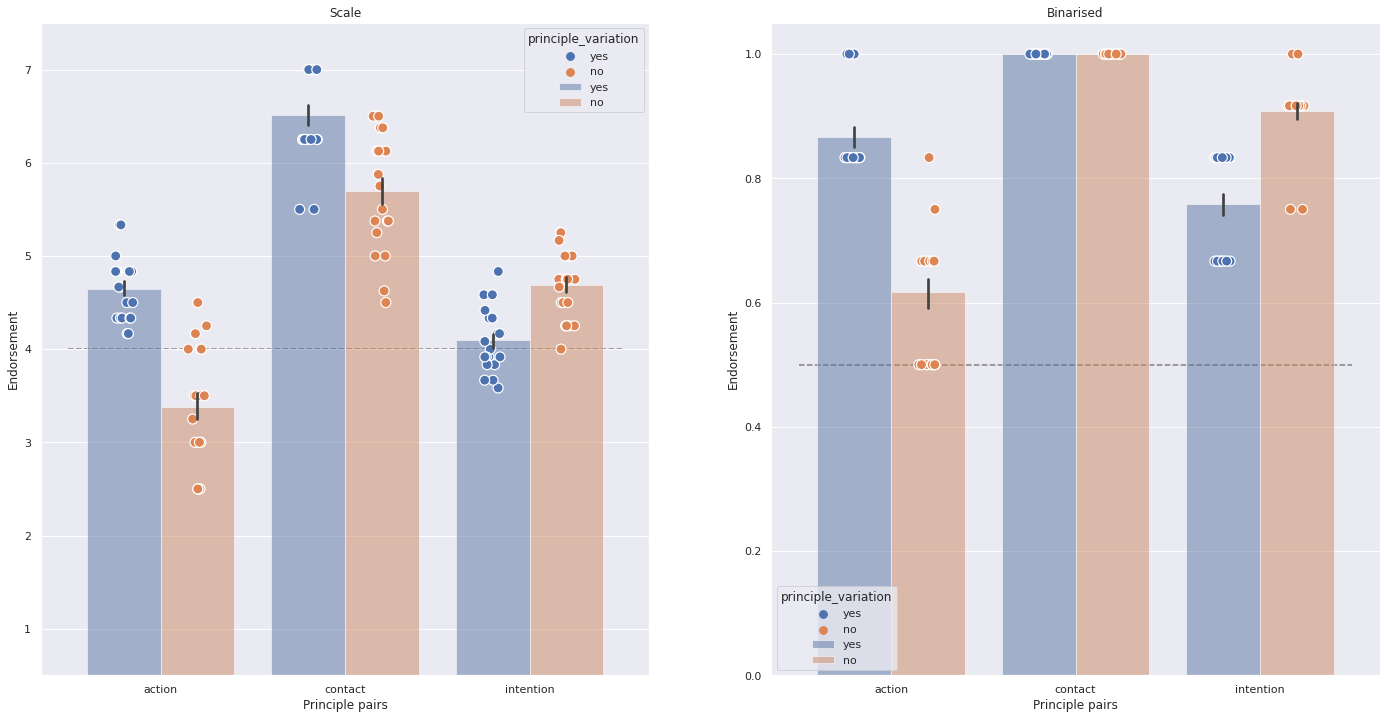

In [15]:
sns.set(rc={'figure.figsize':(12*2, 12)})
df3 = new_df.groupby(['principle', 'iter', 'meta_principle'], as_index=False).mean()
df3['principle_variation'] = 'yes'
df3.loc[df3['principle'].isin(['no_contact', 'foreseen', 'inaction']), 'principle_variation'] = 'no'

plt.subplot(1, 2, 1)
sns.stripplot(x='meta_principle', y='val', hue='principle_variation', data=df3, size=10, linewidth=1.2, zorder=2, edgecolor='white', dodge=True)
sns.barplot(x='meta_principle', y='val', hue='principle_variation', data=df3, alpha=.5, zorder=1, ci=68, dodge=True)
# raincloud(x='exp', y='yes', markersize=9, df=df2)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [4, 4], ls='--', color='gray', zorder=0)
plt.ylim(0.5,7.5)
plt.xlabel('Principle pairs')
plt.ylabel('Endorsement')
plt.title('Scale')


plt.subplot(1, 2, 2)
sns.stripplot(x='meta_principle', y='yes', hue='principle_variation', data=df3, size=10, linewidth=1.2, zorder=2, edgecolor='white', dodge=True)
sns.barplot(x='meta_principle', y='yes', hue='principle_variation', data=df3, alpha=.5, zorder=1, ci=68, dodge=True)
# raincloud(x='exp', y='yes', markersize=9, df=df2)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
plt.xlabel('Principle pairs')
plt.ylabel('Endorsement')
plt.title('Binarised scale')




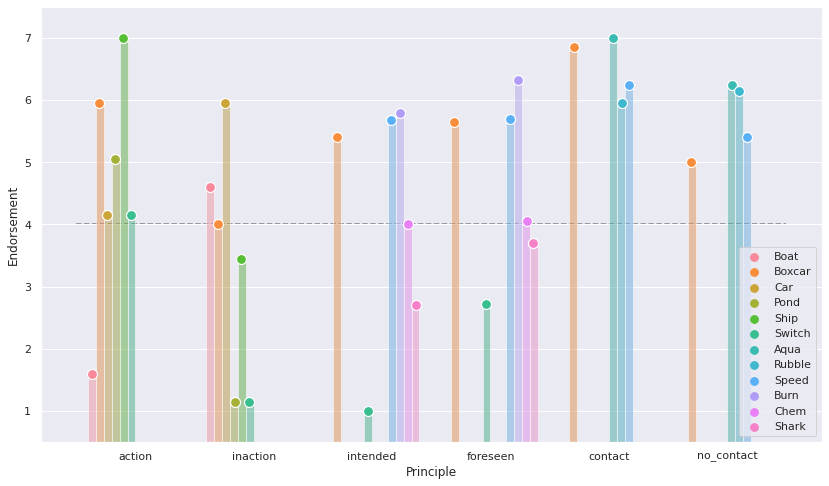

In [18]:
sns.set(rc={'figure.figsize':(14, 8)})

order = ['action', 'inaction', 'intended', 'foreseen', 'contact', 'no_contact']
df3 = new_df.groupby(['principle', 'item'], as_index=False).mean()

sns.stripplot(x='principle', y='val', hue='item', data=df3,
    size=10, linewidth=1.2, zorder=2, edgecolor='white', dodge=True, order=order)

g = sns.barplot(x='principle', y='val', hue='item', data=df3,
    alpha=.5, zorder=1, ci=68, dodge=True, order=order)

# s.legend_.show()
# raincloud(x='exp', y='yes', markersize=9, df=df2)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [4, 4], ls='--', color='gray', zorder=0)
plt.ylim(0.5,7.5)
plt.xlabel('Principle')
plt.ylabel('Endorsement')

h, l = g.get_legend_handles_labels()
plt.legend(h[:12], l[:12], loc='lower right')


In [ ]:

def f(s, v, props): return np.where(s.isin([v]), props, '')
s = df_table.style
df_table.loc[df_table['replicates']==True, 'replicates'] = '✅'
df_table.loc[df_table['replicates']==False, 'replicates'] = '❌'

df_table
# s.apply(f, v=True, props="color: lightgreen;", axis=0)\
# .apply(f, v=False, props="color: white; background-color:pink", axis=0)
# df_table.style.apply(f, v=False, props="color:lightred;", axis=0)